In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")
%matplotlib inline

In [2]:
#print(data[4])

In [3]:

#bitcoin
#url = 'https://api.binance.com/api/v1/klines?symbol=BTCUSDT&interval=15m'

##url = 'https://api.binance.com/api/v1/klines?symbol=BTCUSDT&interval=15m'

#url = 'https://api.binance.com/api/v1/klines?symbol=BTCUSDT&interval=1h'
#url = 'https://api.binance.com/api/v1/klines?symbol=BTCUSDT&interval=1d'
url = 'https://api.binance.com/api/v1/klines?symbol=BTCUSDT&interval=3d'
#ethereum
#url = 'https://api.binance.com/api/v1/klines?symbol=ETHUSDT&interval=1d'
#url = 'https://api.binance.com/api/v1/klines?symbol=ETHUSDT&interval=15m'
#url = 'https://api.binance.com/api/v1/klines?symbol=ETHUSDT&interval=1M'


import requests
from pandas.io.json import json_normalize
import pandas as pd

url = "https://api.exchangerate-api.com/v4/latest/USD"
df = pd.read_json(url)
df.columns = ["openTime","Open","High","Low","Close","Volume","CloseTime","QuoteAssetVolume","NumberofTrades","TakerbuyBaseAssetVolume","TakerbuyQuoteAssetVolume","Ignore"]

print(df)
#df_close=df[4]
#print(df_close)




ValueError: Length mismatch: Expected axis has 7 elements, new values have 12 elements

In [ ]:
#df = pd.read_csv("convertcsvBT5min.csv") #5minutes

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.head()

In [ ]:
#df = df[["Close"]]
#df = df["Close"]

In [ ]:
df.Close

In [ ]:
df.describe()

In [ ]:
plt.figure(1, figsize=(20,5)) 
_ = plt.plot(df.Close)

Calculate the percetange change

https://en.wikipedia.org/wiki/Stationary_process




In [ ]:
df["returns"] = df['Close'].pct_change()

In [ ]:
df

In [ ]:
52394.40/52252.27 - 1

Calculate the log returns

Why use log returns:
https://quantivity.wordpress.com/2011/02/21/why-log-returns


In [ ]:
df["log_returns"] = np.log(1+df["returns"])

In [ ]:
df.head(5)

In [ ]:
plt.figure(1, figsize=(16,4))
plt.plot(df.log_returns)

In [ ]:
#quitamos los num's ceros y na p simplif
df.dropna(inplace=True)
X = df[["Close","log_returns"]].values

In [ ]:
#matrix con 2 valores
X

In [ ]:
#para normalizar proximam
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1)).fit(X)

In [ ]:
X_scaled = scaler.transform(X)

In [ ]:
X_scaled[:5]

In [ ]:
y = [x[0] for x in X_scaled]

In [ ]:
#serie de precios - precio del dia siguiente 
y[:5]

In [ ]:
#dividir nuestros datos en Train y en Test

In [ ]:
split = int(len(X_scaled)*0.8)

In [ ]:
print(split)  # es el .80 qty para Train

In [ ]:
X_train = X_scaled[:split]

In [ ]:
X_test = X_scaled[split:len(X_scaled)]


In [ ]:
len(X_test)  #qty for test

In [ ]:
y_train = y[:split]

In [ ]:
y_test = y[split:len(y)]

In [ ]:
#solo para asegurarnos q son iguales, si son difs es un error
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [ ]:
X_train

In [ ]:
y_train

Labeling using LSTM

memoria corto plazo,  el RNN (no memoriza)
output  t+1

In [ ]:
n = 3
Xtrain = []
ytrain = []
Xtest = []
ytest = []

for i in range(n, len(X_train)):
    Xtrain.append(X_train[i - n : i, : X_train.shape[1]])
    ytrain.append(y_train[i])  #predict next record
for i in range(n, len(X_test)):
    Xtest.append(X_test[i-n:i, : X_test.shape[1]])
    ytest.append(y_test[i])  #predict next record

In [ ]:
df.head(5)

In [ ]:
Xtrain[0]

In [ ]:
ytrain[0]

In [ ]:
val = np.array(ytrain[0])
val = np.c_[val, np.zeros(val.shape)]

In [ ]:
scaler.inverse_transform(val)

In a LSTM network the input for each LSTM layer needs next informaiton:
- The number of observations
- The time steps
- The features

Therefore we need to add a temporal dimension compared to a classical network:
(number of observatios, number of steps, number of features per step)



In [ ]:
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))

In [ ]:
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))


In [ ]:
Xtest, ytest = (np.array(Xtest), np.array(ytest))

In [ ]:
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

In [ ]:
print(Xtrain.shape)
print(ytrain.shape)
print("---")
print(Xtest.shape)
print(ytest.shape)

### install tensorflow and keras


https://margaretmz.medium.com/anaconda-jupyter-notebook-tensorflow-and-keras-b91f381405f8

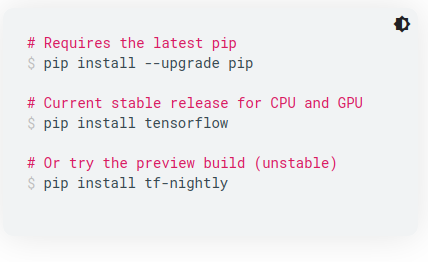




In [ ]:
#pip install tensorflow (es para cuando tienes GPU (acelerador grafico en la lap))
#pip install tf-nightly (para cuando no tienes acelerador grafico)
#pip install keras

In [ ]:
#verificamos si está instalado el tensorflow
#print ("TensorFlow version: " + tf.__version__)

### LSTM Model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(
    Xtrain, ytrain, epochs=100, validation_data=(Xtest, ytest), batch_size=16, verbose=1
)

In [ ]:
model.summary()

In [ ]:
trainPredict = model.predict(Xtrain)
testPredict = model.predict(Xtest)

In [ ]:
trainPredict = np.c_[trainPredict, np.zeros(trainPredict.shape)]
testPredict = np.c_[testPredict, np.zeros(testPredict.shape)]

In [ ]:
#invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainPredict = [x[0] for x in trainPredict]

testPredict = scaler.inverse_transform(testPredict)
testPredict = [x[0] for x in testPredict]

In [ ]:
print(trainPredict[:20])
print(testPredict[:20])

In [ ]:
print(trainPredict)


In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
#calculate root mean squared error
trainScore = mean_squared_error([x[0][0] for x in Xtrain], trainPredict, squared=False)
print("Train Score: %.2f RMSE" % (trainScore))

In [ ]:
testScore = mean_squared_error([x[0][0] for x in Xtest], testPredict, squared=False)
print("Test Score: %.2f RMSE" % (testScore))

In [ ]:
plt.figure(1, figsize=(16,6)) 
_ = plt.plot(trainPredict[:20])

In [ ]:
# Apilar los __DataFrames__ uno encima del otro
type(df.Close)

In [ ]:
type(trainPredict[:20])

In [ ]:
df_close_list = df.Close.tolist()

In [ ]:
tendencia = df_close_list + trainPredict[:20]

In [ ]:
plt.figure(1, figsize=(16,6)) 
_ = plt.plot(df_close_list)

In [ ]:
plt.figure(1, figsize=(16,6)) 
_ = plt.plot(tendencia)